Creative Commons CC BY 4.0 Lynd Bacon & Associates, Ltd. Not warranted to be suitable for any particular purpose. (You're on your own!)

# Regression Regularization By "Shrinkage"

The basic idea is that a model can be "regularized" by adding a _regularizer_ to the cost function, the function that an algorithm minimizes during learning.  (Goodfellow et al., 2016, p. 116).

For example, a regression model of the sort we've trained on the patient satisfaction data and on the radon data might have a "weight decay" function added to the MSE to be minimized that can "shrink" coefficients to be learned towards zero. The shrinkage effect of such a regularizer is determined by one or more parameters specified a priori for training.  The result can be a decrease in variance. ([James et al., 2017](http://www-bcf.usc.edu/~gareth/ISL/), p. 214.) 

Frequently used regression algorithms that can apply this kind regularization method are:

* Ridge regression
* Lasso
* elasticNet

We'll experiment with Ridge regression in the following using the radon data, and observe the effect of adjusting the regularization parameter, referred to here as _alpha_.  We'll do a _grid search_ to find a "good" value of _alpha_.  In a subsequent notebook, we'll consider the Lasso and elasticNet, we'll do an analogous search, and will do some rescaling of the data.

Ridge uses _L2_ regularization.  This essentially consists of adding penalty to the cost (or loss) function to be minimized that's a constant (alpha, here) times the L2 ("Euclidean") norm of the weights (regression coefficients) being learned. A _norm_ is the length of a vector.    In the case of Ridge regression, the L2 norm is the sum of the squared weights.

The effect of using L2 regularization is to shrink model weights towards zero.  The amount of shrinkage that occurs depends on the value of `alpha`.  The larger the `alpha`, the greater the shrinkage.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import linear_model  
from sklearn.metrics import mean_squared_error, r2_score # Basic metrics
from sklearn.model_selection import GridSearchCV, train_test_split

# Getting Some Radon 

This is pretty much the same as done previously.

In [2]:
# input data, examine col names

radon=pd.read_csv('DATA/ML/radon.csv')
radon.columns

Index(['fips', 'state', 'county', 'lcanmort', 'radon', 'lnradon', 'obesity',
       'over65', 'cursmoke', 'evrsmoke', 'hhincome'],
      dtype='object')

In [3]:
# select cols to be used

radon2=radon[['lcanmort', 'lnradon', 'obesity',
       'over65', 'cursmoke', 'evrsmoke', 'hhincome']]
radon2.columns

Index(['lcanmort', 'lnradon', 'obesity', 'over65', 'cursmoke', 'evrsmoke',
       'hhincome'],
      dtype='object')

In [16]:
#  Get rid of that row with missing hhincome

radon3=radon2[radon2.hhincome.notnull()]
radon3.columns

Index(['lcanmort', 'lnradon', 'obesity', 'over65', 'cursmoke', 'evrsmoke',
       'hhincome'],
      dtype='object')

In [17]:
# create numpy arrays for lcanmort and for the predictors
# check to see if resulting shapes are correct

y=radon3.lcanmort.to_numpy()
X=radon3.iloc[:,1:].to_numpy()
y.shape
X.shape

(2880,)

(2880, 6)

# Ridge Regression

We'll use the `scikit-learn` method [linear.model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).  

The parameter that regularizes this algorithm is `alpha`.  In principle it can be in the range $\big [ 0, \infty \big )$.  Zero results in no regularization, and larger values of `alpha` produce larger amounts of regularization.  Note that the scikit-learn documentation advises that if no regularization is to be used, it's better to use another algorithm, something that does plain vanilla linear regression, for example.  Note that if alpha were to be $\lt$ 0, training would result in _larger_ weights, if it worked at all.

For any particular application, the problem is to pick a "good" value of `alpha`, a value that will result in pretty good generalization.  We can search for an `alpha` value that works well enough by doing what's called a _grid search_.  We'll use 10 fold CV.  Here we go.

First, let's split X and y into training and test subsets:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)
X_train.shape
X_test.shape
y_train.shape
X_test.shape

(2160, 6)

(720, 6)

(2160,)

(720, 6)

## Grid Search for "Best" Ridge Regularization Parameter Value

The accuracy measures returned from Ridge will be $R^2$ estimates by default.

Here we're using scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) method.

In [22]:
ridgeReg=linear_model.Ridge()  # ridge model instance
alpha_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100,1000]}
grid = GridSearchCV(ridgeReg, param_grid=alpha_grid, cv=10, refit=True)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test, y_test)))

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best cross-validation accuracy: 0.46
Best parameters:  {'alpha': 10}
Test set accuracy: 0.48


## What Happened?

The results indicate that `alpha` = 10 is the "best" value for `alpha` amongst the seven different values tried, where "best" is defined by the value of R<sup>2</sup> when the test data are predicted.

Let's take a look at the results for each value of `alpha`.  In ascending order of `alpha` values:

In [24]:
pd.DataFrame(grid.cv_results_)[['param_alpha','mean_test_score']]. \
    sort_values(by='param_alpha')

,param_alpha,mean_test_score
0,0.001,0.455810
1,0.01,0.455810
2,0.1,0.455810
3,1,0.455811
4,10,0.455813
5,100,0.455552
6,1000,0.442341


You can see that as `alpha` increased, the mean "test score" ($R^2$), increased until `alpha` = 10, and then it decreased.  As `alpha` increased, variance decreased.  But bias increased due to the model being less and less able to follow variations in `lcanmort`. 

We can get predictions of `lcanmort` using the best `alpha` value found:

In [25]:
predLcaTrain=grid.predict(X_train)
trainMSE=mean_squared_error(predLcaTrain,y_train)
predLcaTest=grid.predict(X_test)
testMSE=mean_squared_error(predLcaTest,y_test)
print("training Data MSE: {:.2f}".format(trainMSE) )
print("test Data MSE: {:.2f}".format(testMSE))

training Data MSE: 165.81
test Data MSE: 168.43


## Plotting Predicted Values Obtained using "Best" Ridge Parameter

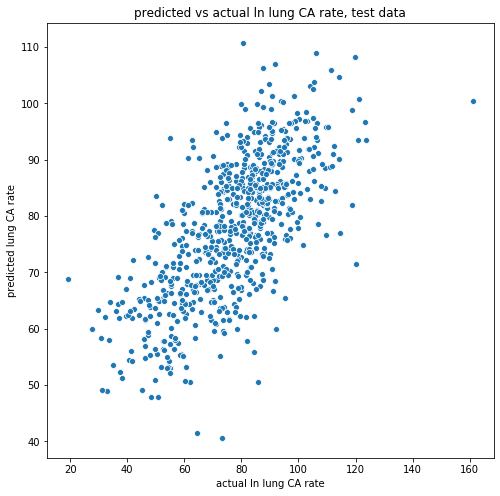

In [15]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=y_test, y=predLcaTest)
plt.title('predicted vs actual ln lung CA rate, test data')
plt.xlabel('actual ln lung CA rate')
plt.ylabel('predicted lung CA rate');

## Last But Not Least,...

There are other ways to do Ridge with CV while trying different values of `alpha`.  One of them is [RidgeCV](scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV).

# UDU :  Do the Above Using the Patient Satisfaction Data